# Overview

This notebook implements Vision Transformer (ViT) model by Alexey Dosovitskiy et al for image classification, and demonstrates it on the Cassava Leaf Disease Classification dataset.

For from scratch implementation of ViT check out this notebook: <br>
https://www.kaggle.com/raufmomin/vision-transformer-vit-from-scratch

Research Paper: https://arxiv.org/pdf/2010.11929.pdf <br>
Github (Official) Link: https://github.com/google-research/vision_transformer <br>
Github (Keras) Link: https://github.com/faustomorales/vit-keras

#### Highlights of this notebook:
1. Pre-trained Vision Transformer (vit_b32) on imagenet21k dataset
2. Label Smoothing of 0.3
3. Custom data augmentation for ImageDataGenerator
4. RectifiedAdam Optimizer


# Model Architecture

![figure1.png](attachment:figure1.png)

# Available models
There are models pre-trained on imagenet21k for the following architectures:
ViT-B/16, ViT-B/32, ViT-L/16, ViT-L/32 and ViT-H/14.
There are also the same models pre-trained on imagenet21k and fine-tuned on imagenet2012.

![image.png](attachment:image.png)

# Libraries and Configurations

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

TRAIN_PATH = '/kaggle/input/ied-data/ied-diversified/train'
TEST_PATH = '/kaggle/input/ied-data/ied-diversified/test'
VAL_PATH = '/kaggle/input/ied-data/ied-diversified/val'

classes = {0 : "cardboard",
           1 : "glass",
           4 : "ied",
           5 : "metal",
           4 : "paper",
           5 : "plastic",
           6 : "trash"}

# Data Augmentations

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)

    return image

# Data Generator

In [ ]:
# Define data generators for train, val, and test sets
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    samplewise_center = True,
    samplewise_std_normalization = True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = data_augment
)


train_gen = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=['cardboard', 'glass','ied', 'metal','paper', 'plastic','trash'])

val_gen = train_datagen.flow_from_directory(
        VAL_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=['cardboard', 'glass','ied', 'metal','paper', 'plastic','trash'])

test_gen = train_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=['cardboard', 'glass','ied', 'metal','paper', 'plastic','trash'])

Found 2994 images belonging to 7 classes.
Found 401 images belonging to 7 classes.
Found 410 images belonging to 7 classes.


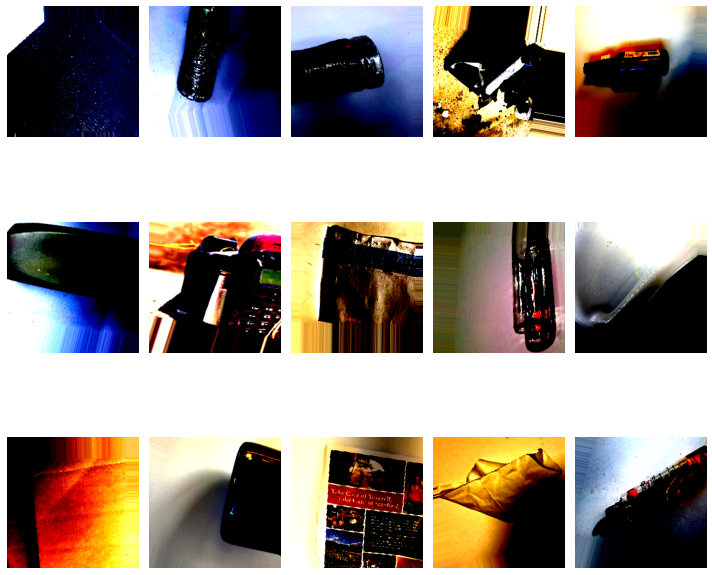

In [ ]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Building the Model

In [ ]:
!pip install --quiet vit-keras

from vit_keras import vit

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 1. ViT B32 Model

In [ ]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 7)

### Visualizing Attention Maps of Sample Test Image

In [ ]:
from vit_keras import visualize

x = test_gen.next()
image = x[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

error: OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/imgproc/src/resize.cpp:3688: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


## 2. Fine-tuning the Model

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 84        
Total params: 87,466,891
Trainable params: 87,465,333
Non-trainable params: 1,558
________________________________

# Training the Model

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = val_gen.n // val_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model_b_32.h5')

Epoch 1/10
93/93 [==============================] - 565s 6s/step - loss: 2.1873 - accuracy: 0.1951 - val_loss: 1.7284 - val_accuracy: 0.4349

Epoch 00001: val_accuracy improved from -inf to 0.43490, saving model to ./model.hdf5
Epoch 2/10
93/93 [==============================] - 469s 5s/step - loss: 1.5704 - accuracy: 0.5240 - val_loss: 1.4497 - val_accuracy: 0.5990

Epoch 00002: val_accuracy improved from 0.43490 to 0.59896, saving model to ./model.hdf5
Epoch 3/10
93/93 [==============================] - 471s 5s/step - loss: 1.3605 - accuracy: 0.6899 - val_loss: 1.3361 - val_accuracy: 0.7057

Epoch 00003: val_accuracy improved from 0.59896 to 0.70573, saving model to ./model.hdf5
Epoch 4/10
93/93 [==============================] - 474s 5s/step - loss: 1.2793 - accuracy: 0.7410 - val_loss: 1.2048 - val_accuracy: 0.7969

Epoch 00004: val_accuracy improved from 0.70573 to 0.79688, saving model to ./model.hdf5
Epoch 5/10
93/93 [==============================] - 466s 5s/step - loss: 1.1826

In [ ]:
model.save('model_b_32.h5')

# Model Results

              precision    recall  f1-score   support

           0       0.17      0.16      0.17        61
           1       0.19      0.18      0.19        76
           2       0.07      0.08      0.07        26
           3       0.08      0.10      0.09        62
           4       0.20      0.18      0.19        90
           5       0.19      0.19      0.19        73
           6       0.15      0.14      0.14        22

    accuracy                           0.16       410
   macro avg       0.15      0.15      0.15       410
weighted avg       0.16      0.16      0.16       410



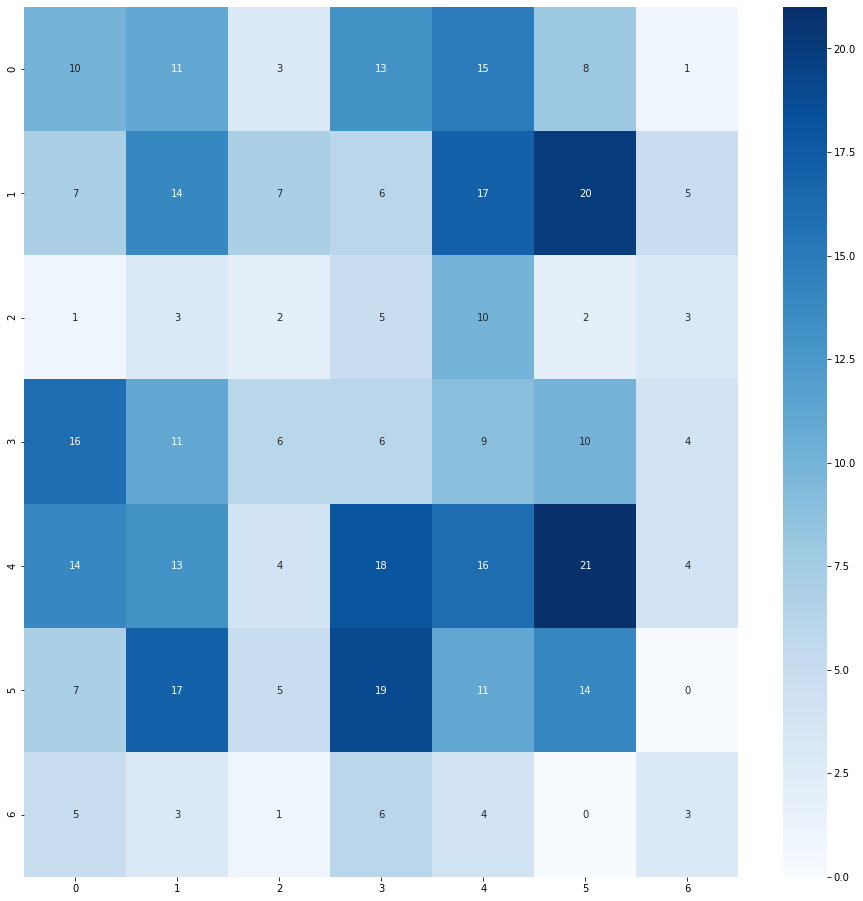

In [ ]:
predicted_classes = np.argmax(model.predict(test_gen, steps = test_gen.n // test_gen.batch_size + 1), axis = 1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

In [ ]:
import tensorflow as tf

# Load the model from the downloaded file
# loaded_model = tf.keras.models.load_model('model16.h5')
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print(f"Test accuracy: {test_acc}")

13/13 - 62s - loss: 0.9681 - accuracy: 0.9049
Test accuracy: 0.9048780202865601


In [ ]:
import cv2

In [ ]:
# for pred, act in zip(predicted_classes, true_classes):
#     print(f"For {class_labels[act]} system predicted  {class_labels[pred]}")

# **Binary Class Classification**

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 7

TRAIN_PATH = '/kaggle/input/ied-data/ctob/train'
TEST_PATH = '/kaggle/input/ied-data/ctob/test'
VAL_PATH = '/kaggle/input/ied-data/ctob/val'

classes = {0 : "ied",
           1 : "nonied"
          }

In [ ]:
# Define data generators for train, val, and test sets
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    samplewise_center = True,
    samplewise_std_normalization = True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = data_augment
)

train_gen = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=['ied', 'nonied'])

val_gen = train_datagen.flow_from_directory(
        VAL_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=['ied', 'nonied'])

test_gen = train_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=['ied', 'nonied'])

Found 1141 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 24        
Total params: 87,466,831
Trainable params: 87,465,273
Non-trainable params: 1,558
________________________________

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = val_gen.n // val_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model_binary_32.h5')

Epoch 1/7
35/35 [==============================] - 202s 4s/step - loss: 1.1269 - accuracy: 0.4720 - val_loss: 0.6878 - val_accuracy: 0.7031

Epoch 00001: val_accuracy improved from -inf to 0.70312, saving model to ./model.hdf5
Epoch 2/7
35/35 [==============================] - 137s 4s/step - loss: 0.5831 - accuracy: 0.8045 - val_loss: 0.4585 - val_accuracy: 0.9297

Epoch 00002: val_accuracy improved from 0.70312 to 0.92969, saving model to ./model.hdf5
Epoch 3/7
35/35 [==============================] - 138s 4s/step - loss: 0.4810 - accuracy: 0.8908 - val_loss: 0.4318 - val_accuracy: 0.9062

Epoch 00003: val_accuracy did not improve from 0.92969
Epoch 4/7
35/35 [==============================] - 137s 4s/step - loss: 0.4356 - accuracy: 0.9306 - val_loss: 0.3992 - val_accuracy: 0.9609

Epoch 00004: val_accuracy improved from 0.92969 to 0.96094, saving model to ./model.hdf5
Epoch 5/7
35/35 [==============================] - 138s 4s/step - loss: 0.4154 - accuracy: 0.9514 - val_loss: 0.3633 

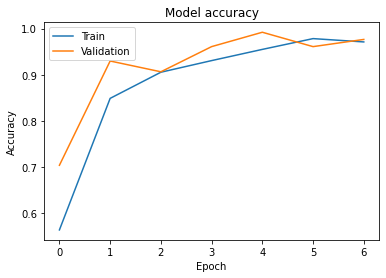

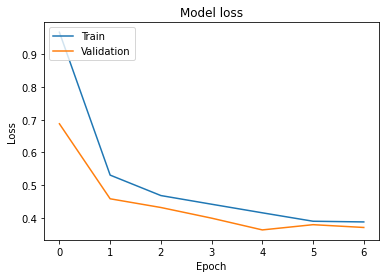

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
history = model.history.history

# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
